In [1]:
!pip install pandas numpy scikit-learn tensorflow yfinance matplotlib scikeras

2025-09-22 13:22:02.665958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_3856345/3527650074.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("ETH-USD", start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3856345/3527650074.py:46: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop("Price_Change", axis=1, inplace=True)


LinearRegression (baseline) | MSE: 12747.10 | RMSE: 112.90 | R2: 0.9753 | Acc(±1.0%): 29.7348%


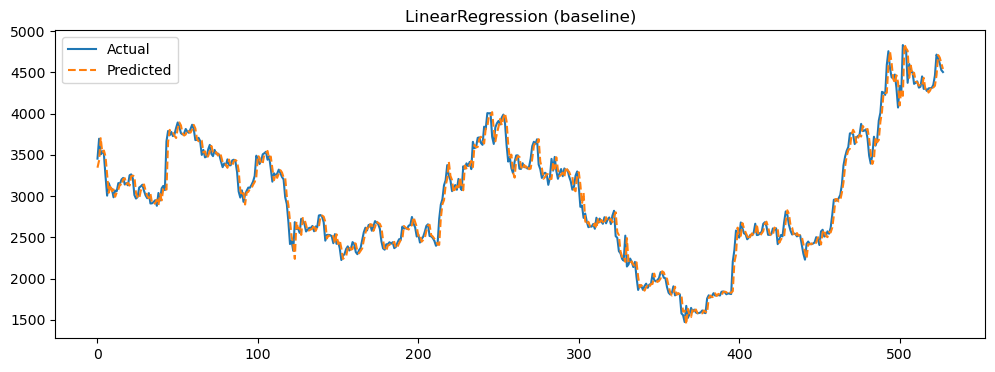

RandomForest best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
RandomForest (GridSearchCV) | MSE: 14529.17 | RMSE: 120.54 | R2: 0.9718 | Acc(±1.0%): 25.9470%


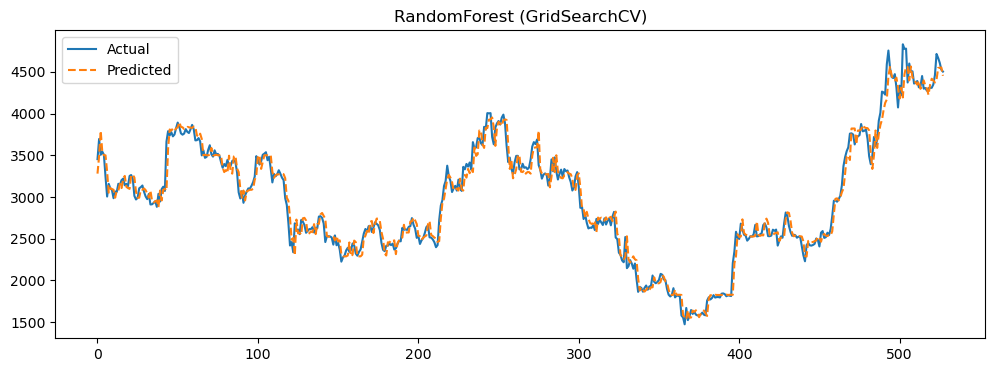

I0000 00:00:1758514950.469135 3856345 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46659 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1f:00.0, compute capability: 8.6
2025-09-22 13:22:34.047126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


LSTM best params: {'batch_size': 32, 'epochs': 20, 'model__dropout': 0.1, 'model__units': 50, 'optimizer': None} Took 119.5s
LSTM (GridSearchCV) | MSE: 100923.29 | RMSE: 317.68 | R2: 0.8041 | Acc(±1.0%): 3.5985%


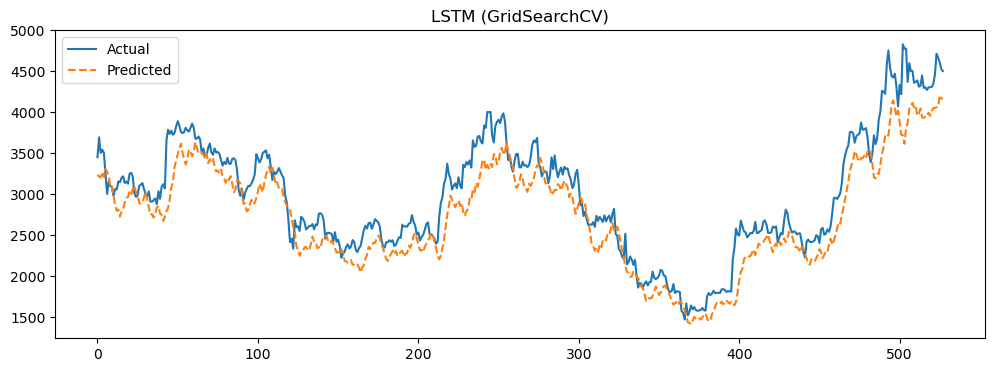

CNN-LSTM best params: {'batch_size': 32, 'epochs': 20, 'model__dropout': 0.1, 'model__filters': 32, 'model__kernel_size': 2, 'model__units': 32} Took 39.6s
CNN-LSTM (GridSearchCV) | MSE: 119095.57 | RMSE: 345.10 | R2: 0.7689 | Acc(±1.0%): 7.9545%


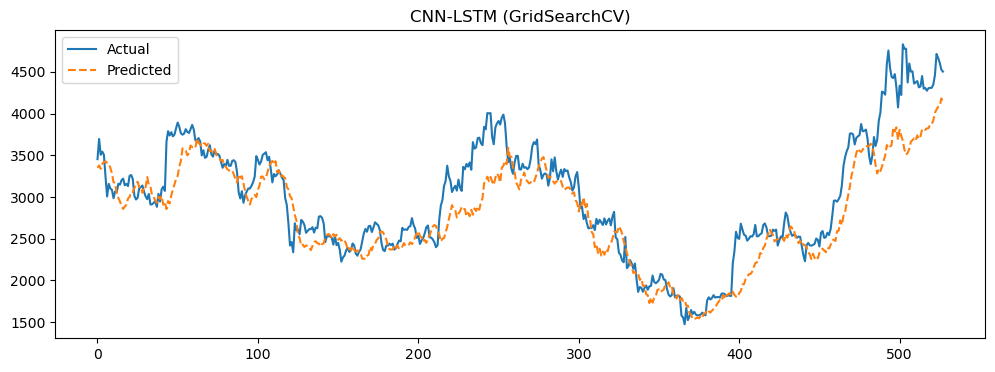

Direction accuracies on sequence test set
LSTM dir acc: 88.76908287419651
CNN-LSTM dir acc: 88.84727961432507


In [2]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

START_DATE = "2016-01-01"
END_DATE = "2025-09-17"
SEQ_LEN = 30
TRAIN_RATIO = 0.8
ACC_THRESHOLD_PERCENT = 1.0
RANDOM_STATE = 42

df = yf.download("ETH-USD", start=START_DATE, end=END_DATE)
if df.empty:
    np.random.seed(RANDOM_STATE)
    dates = pd.date_range(start=START_DATE, end=END_DATE, freq="D")
    close = 100 + np.cumsum(np.random.randn(len(dates)) * 5)
    open_ = close - np.random.randn(len(dates)) * 2
    high = np.maximum(close, open_) + np.abs(np.random.randn(len(dates)) * 3)
    low = np.minimum(close, open_) - np.abs(np.random.randn(len(dates)) * 3)
    vol = np.random.randint(1_000_000, 10_000_000, len(dates))
    df = pd.DataFrame({"Open": open_, "High": high, "Low": low, "Close": close, "Volume": vol}, index=dates)
df = df[["Open", "High", "Low", "Close", "Volume"]]

df["MA50"] = df["Close"].rolling(50).mean()
df["MA200"] = df["Close"].rolling(200).mean()
lags = [1, 2, 3]
for c in ["Close", "High", "Low", "Volume"]:
    for l in lags:
        df[f"{c}_lag_{l}"] = df[c].shift(l)
df["Price_Change"] = df["Close"].diff()
df["Sentiment"] = 0.0
df.loc[df["Price_Change"] > 0, "Sentiment"] = np.random.uniform(0.1, 1.0, (df["Price_Change"] > 0).sum())
df.loc[df["Price_Change"] < 0, "Sentiment"] = np.random.uniform(-1.0, -0.1, (df["Price_Change"] < 0).sum())
df.drop("Price_Change", axis=1, inplace=True)
df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)
features = [
    "Open", "High", "Low", "Close", "Volume", "MA50", "MA200",
    *[f"Close_lag_{l}" for l in lags],
    *[f"High_lag_{l}" for l in lags],
    *[f"Low_lag_{l}" for l in lags],
    *[f"Volume_lag_{l}" for l in lags],
    "Sentiment"
]
X = df[features].values
y = df["Target"].values.reshape(-1, 1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

def create_sequences(data_X, data_y, seq_len):
    Xs, ys = [], []
    for i in range(len(data_X) - seq_len):
        Xs.append(data_X[i : i + seq_len])
        ys.append(data_y[i + seq_len])
    return np.array(Xs), np.array(ys)

X_seq_all, y_seq_all = create_sequences(X_scaled, y_scaled, SEQ_LEN)
n_seq = len(X_seq_all)
train_n = int(n_seq * TRAIN_RATIO)
X_train_seq = X_seq_all[:train_n]
y_train_seq = y_seq_all[:train_n].reshape(-1, 1)
X_test_seq = X_seq_all[train_n:]
y_test_seq = y_seq_all[train_n:].reshape(-1, 1)
test_start_index = SEQ_LEN + train_n
y_test_original_seq = scaler_y.inverse_transform(y_test_seq).flatten()
prices_full = df["Close"].values
prices_for_dir = prices_full[test_start_index - 1 : test_start_index - 1 + len(y_test_original_seq)]

X_flat = X_scaled[SEQ_LEN:]
y_flat = y_scaled[SEQ_LEN:].reshape(-1, 1)
train_flat_n = int(len(X_flat) * TRAIN_RATIO)
X_train_flat = X_flat[:train_flat_n]
y_train_flat = y_flat[:train_flat_n]
X_test_flat = X_flat[train_flat_n:]
y_test_flat = y_flat[train_flat_n:]
y_test_original_flat = scaler_y.inverse_transform(y_test_flat).flatten()

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    thresh = (ACC_THRESHOLD_PERCENT / 100.0) * np.abs(y_true)
    acc = (np.abs(y_true - y_pred) <= thresh).mean() * 100
    print(f"{name} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.4f} | Acc(±{ACC_THRESHOLD_PERCENT}%): {acc:.4f}%")
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted", linestyle="--")
    plt.title(name)
    plt.legend()
    plt.show()
    return mse, rmse, r2, acc

lr = LinearRegression()
lr.fit(X_train_flat, y_train_flat)
y_pred_lr = lr.predict(X_test_flat)
y_pred_lr_orig = scaler_y.inverse_transform(y_pred_lr.reshape(-1,1)).flatten()
evaluate(y_test_original_flat, y_pred_lr_orig, "LinearRegression (baseline)")

rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}
tscv = TimeSeriesSplit(n_splits=3)
gcv_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1)
gcv_rf.fit(X_train_flat, y_train_flat.ravel())
best_rf = gcv_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_flat)
y_pred_rf_orig = scaler_y.inverse_transform(y_pred_rf.reshape(-1,1)).flatten()
print("RandomForest best params:", gcv_rf.best_params_)
evaluate(y_test_original_flat, y_pred_rf_orig, "RandomForest (GridSearchCV)")

def build_lstm(units=50, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Input(shape=(SEQ_LEN, X_train_seq.shape[2])))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units//1, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mean_squared_error")
    return model

keras_lstm = KerasRegressor(model=build_lstm, verbose=0)
param_grid_lstm = {
    "model__units": [32, 50],
    "model__dropout": [0.1, 0.2],
    "optimizer": [None],
    "batch_size": [32],
    "epochs": [20]
}
gcv_lstm = GridSearchCV(keras_lstm, param_grid_lstm, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
start = time.time()
gcv_lstm.fit(X_train_seq, y_train_seq)
end = time.time()
best_lstm = gcv_lstm.best_estimator_
print("LSTM best params:", gcv_lstm.best_params_, "Took {:.1f}s".format(end-start))
y_pred_lstm = best_lstm.predict(X_test_seq)
y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).flatten()
evaluate(y_test_original_seq, y_pred_lstm_orig, "LSTM (GridSearchCV)")

def build_cnn_lstm(filters=32, kernel_size=2, units=50, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Input(shape=(SEQ_LEN, X_train_seq.shape[2])))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units//1, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mean_squared_error")
    return model

keras_cnn_lstm = KerasRegressor(model=build_cnn_lstm, verbose=0)
param_grid_cnn_lstm = {
    "model__filters": [32],
    "model__kernel_size": [2],
    "model__units": [32],
    "model__dropout": [0.1],
    "batch_size": [32],
    "epochs": [20]
}
gcv_cnn = GridSearchCV(keras_cnn_lstm, param_grid_cnn_lstm, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
start = time.time()
gcv_cnn.fit(X_train_seq, y_train_seq)
end = time.time()
best_cnn = gcv_cnn.best_estimator_
print("CNN-LSTM best params:", gcv_cnn.best_params_, "Took {:.1f}s".format(end-start))
y_pred_cnn = best_cnn.predict(X_test_seq)
y_pred_cnn_orig = scaler_y.inverse_transform(y_pred_cnn.reshape(-1,1)).flatten()
evaluate(y_test_original_seq, y_pred_cnn_orig, "CNN-LSTM (GridSearchCV)")

def direction_accuracy(today_prices, actual_next, pred_next):
    act_dir = np.sign(actual_next - today_prices)
    pred_dir = np.sign(pred_next - today_prices)
    return (act_dir == pred_dir).mean() * 100

print("Direction accuracies on sequence test set")
print("LSTM dir acc:", direction_accuracy(prices_for_dir, y_test_original_seq, y_pred_lstm_orig))
print("CNN-LSTM dir acc:", direction_accuracy(prices_for_dir, y_test_original_seq, y_pred_cnn_orig))
